Credit modelling using financial lending data from Lending Club
------------------------------------------

* Using False Positive Rate as error matric
* Using weighted training penalty to solve the imblance binary classfication

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_predict, KFold


#######Filtering Function########
def Filter(df, key, value):
	return df[df[key] == value]
pd.DataFrame.Filter = Filter

/home/dawei/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import keras.callbacks as cb
from keras.datasets import mnist
from keras.layers.core import Activation, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import SGD,Adam
from keras.regularizers import l1, l2
from keras.utils import np_utils

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import time
import pandas as pd


Using TensorFlow backend.


In [3]:
## Define Features Columns and target Columns

loans=pd.read_csv('Processed/Cleaned_loans_2007.csv',index_col=False,low_memory=False)
cols = loans.columns
train_cols = cols.drop("loan_status")
features = loans[train_cols]
target = loans["loan_status"]

## Algorithm 1: Logistic Regression

* Class weight with balanced penality to solve the imbalance target columbn
* Class weight with self-defined penality to solve the imbalance target columbn


### Class weight with balanced penality to solve the imbalance target columbn

In [4]:
###########################################################
#################Weight with balanced penality#############

lr = LogisticRegression(class_weight="balanced")
kf = KFold(features.shape[0], random_state=1)
predictions = cross_val_predict(lr, features, target, cv=kf)
predictions = pd.Series(predictions)

# False positives.
fp_filter = (predictions == 1) & (loans["loan_status"] == 0)
fp = len(predictions[fp_filter])

# True positives.
tp_filter = (predictions == 1) & (loans["loan_status"] == 1)
tp = len(predictions[tp_filter])

# False negatives.
fn_filter = (predictions == 0) & (loans["loan_status"] == 1)
fn = len(predictions[fn_filter])

# True negatives
tn_filter = (predictions == 0) & (loans["loan_status"] == 0)
tn = len(predictions[tn_filter])

# Rates
tpr = tp / float(tp + fn)
fpr = fp / float(fp + tn)
accuracy = (tp+tn)/float(tp+fp+tn+fn)

print("Test tpr is {:.2f}%, fpr is {:.2f}%, Accuracy is {:.2f}%".format(tpr*100, fpr*100,accuracy*100))


Test tpr is 66.52%, fpr is 38.93%, Accuracy is 65.73%


### Class weight with self-defined penality to solve the imbalance target columbn

In [5]:
###########################################################
#################Weight with manual penality###############


penalty = {
    0: 10,
    1: 1
}

lr = LogisticRegression(class_weight=penalty)
kf = KFold(features.shape[0], random_state=1)
predictions = cross_val_predict(lr, features, target, cv=kf)
predictions = pd.Series(predictions)

# False positives.
fp_filter = (predictions == 1) & (loans["loan_status"] == 0)
fp = len(predictions[fp_filter])

# True positives.
tp_filter = (predictions == 1) & (loans["loan_status"] == 1)
tp = len(predictions[tp_filter])

# False negatives.
fn_filter = (predictions == 0) & (loans["loan_status"] == 1)
fn = len(predictions[fn_filter])

# True negatives
tn_filter = (predictions == 0) & (loans["loan_status"] == 0)
tn = len(predictions[tn_filter])

# Rates
tpr = tp / float(tp + fn)
fpr = fp / float(fp + tn)
accuracy = (tp+tn)/float(tp+fp+tn+fn)

print("Test tpr is {:.2f}%, fpr is {:.2f}%, Accuracy is {:.2f}%".format(tpr*100, fpr*100,accuracy*100))

Test tpr is 23.13%, fpr is 8.41%, Accuracy is 33.02%


## Algorithm 2: Random Forest

* Class weight with balanced penality to solve the imbalance target columbn


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_predict
rf = RandomForestClassifier(n_estimators = 30,class_weight="balanced", random_state=1)
kf = KFold(features.shape[0], random_state=1)
predictions = cross_val_predict(rf, features, target, cv=kf)
predictions = pd.Series(predictions)

# False positives.
fp_filter = (predictions == 1) & (loans["loan_status"] == 0)
fp = len(predictions[fp_filter])

# True positives.
tp_filter = (predictions == 1) & (loans["loan_status"] == 1)
tp = len(predictions[tp_filter])

# False negatives.
fn_filter = (predictions == 0) & (loans["loan_status"] == 1)
fn = len(predictions[fn_filter])

# True negatives
tn_filter = (predictions == 0) & (loans["loan_status"] == 0)
tn = len(predictions[tn_filter])


# Rates
tpr = tp / float(tp + fn)
fpr = fp / float(fp + tn)
accuracy = (tp+tn)/float(tp+fp+tn+fn)

print("Test tpr is {:.2f}%, fpr is {:.2f}%, Accuracy is {:.2f}%".format(tpr*100, fpr*100,accuracy*100))

Test tpr is 99.53%, fpr is 98.24%, Accuracy is 85.40%


## Algorithm 3: Deep FNN


### Pre-processing

* proceed w/ standardizing datasets by z-scoring (de-mean, uni-variance).

* Training Data Ratio = 0.9

In [7]:
def PreprocessDataset():
    from sklearn import preprocessing
    data = pd.read_csv('Processed/Cleaned_loans_2007.csv',index_col=False,low_memory=False)
    data = data.reindex(np.random.permutation(data.index))
    cols = data.columns
    x_columns = cols.drop("loan_status")
    
    x = data[x_columns]
    y = data["loan_status"]
    
    train_max_row = int(data.shape[0]*0.9)
    
    x_train = x.iloc[:train_max_row]
    x_test = x.iloc[train_max_row:]
    
    y_train = y.iloc[:train_max_row]
    y_test = y.iloc[train_max_row:]
    
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)
    
    ################Pre-processing###########
    x_train = preprocessing.scale(x_train)
    x_test = preprocessing.scale(x_test)
    
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = PreprocessDataset()

## Recipes for Neural Nets

* Number of Layer: 5

* Activation Fuction: ReLU

* Droupout Rate: 0.5 

* Learning Rate: 0.005

* Weight Regularizer: None

* Optimization Methon: Adam

* Number of Batch: 512

* Number of epoch: 20



In [8]:
def DefineModel():


    activation_func = 'relu' 
    loss_function = 'categorical_crossentropy'
    #loss_function = 'mean_squared_error'
      
    dropout_rate = 0.1
    weight_regularizer = None

    learning_rate = 0.005
    
    ## Initialize model.
    model = Sequential()

    ## 1st Layer
    ## Dense' means fully-connected.
    model.add(Dense(64, input_dim=37, W_regularizer=weight_regularizer))
    model.add(Activation(activation_func))
    model.add(Dropout(0.5))
    
    ## 2nd Layer
    model.add(Dense(32, W_regularizer=weight_regularizer))
    model.add(Activation(activation_func))
    model.add(Dropout(0.5))
    
     ## 2nd Layer
    model.add(Dense(28, W_regularizer=weight_regularizer))
    model.add(Activation(activation_func))
    model.add(Dropout(0.5))
    
     ## 2nd Layer
    model.add(Dense(24, W_regularizer=weight_regularizer))
    model.add(Activation(activation_func))
    model.add(Dropout(0.5))
    
     ## 2nd Layer
    model.add(Dense(20, W_regularizer=weight_regularizer))
    model.add(Activation(activation_func))
    model.add(Dropout(0.5))
    
     ## 2nd Layer
    model.add(Dense(16, W_regularizer=weight_regularizer))
    model.add(Activation(activation_func))
    model.add(Dropout(dropout_rate))
    
     ## 2nd Layer
    model.add(Dense(12, W_regularizer=weight_regularizer))
    model.add(Activation(activation_func))
    model.add(Dropout(dropout_rate))
    
     ## 2nd Layer
    model.add(Dense(8, W_regularizer=weight_regularizer))
    model.add(Activation(activation_func))
    model.add(Dropout(0.7))
    
    ## 3rd Layer
    model.add(Dense(4))
    model.add(Activation(activation_func))   
    model.add(Dropout(0.25))
    
    ## 4th Layer
    model.add(Dense(4))
    model.add(Activation(activation_func))   
    model.add(Dropout(0.25))
    
    ## 5th Layer
    model.add(Dense(4))
    model.add(Activation(activation_func))   
    model.add(Dropout(0.25))

    
    ## Adding Softmax Layer
    ## Last layer has the same dimension as the number of classes
    model.add(Dense(2))
    
    ## For classification, the activation is softmax
    model.add(Activation('softmax'))
    
    ## Define optimizer. we select Adam
    opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    #opt = SGD(lr=learning_rate, clipnorm=5.)
    
    ## Define loss function = 'categorical_crossentropy' or 'mean_squared_error'
    model.compile(loss=loss_function, optimizer=opt, metrics=["fpr","accuracy"])

    return model

In [9]:
def TrainModel(data=None, epochs=20):

    batch=128
    start_time = time.time()
    model = DefineModel()
    if data is None:
        print("Must provide data.")
        return
    x_train, x_test, y_train, y_test = data
    print('Start training.')

    history = model.fit(x_train[:32000], y_train[:32000], nb_epoch=epochs, batch_size=batch,class_weight={0:3,1:1},
              validation_data=(x_train[32000:], y_train[32000:]))
    print("Training took {0} seconds.".format(time.time() - start_time))
    return model, history

### Start Training

In [10]:
trained_model, training_history = TrainModel(data=[x_train, x_test, y_train, y_test],epochs = 20)

Start training.
Train on 32000 samples, validate on 3002 samples
Epoch 1/20
32000/32000 [==============================] - 1s - loss: 1.0864 - fpr: 0.1502 - acc: 0.8482 - val_loss: 0.6293 - val_fpr: 0.1456 - val_acc: 0.8544
Epoch 2/20
32000/32000 [==============================] - 1s - loss: 1.0859 - fpr: 0.1452 - acc: 0.8548 - val_loss: 0.6333 - val_fpr: 0.1456 - val_acc: 0.8544
Epoch 3/20
32000/32000 [==============================] - 1s - loss: 1.0852 - fpr: 0.1451 - acc: 0.8549 - val_loss: 0.6441 - val_fpr: 0.1456 - val_acc: 0.8544
Epoch 4/20
32000/32000 [==============================] - 1s - loss: 1.0854 - fpr: 0.1436 - acc: 0.8564 - val_loss: 0.6224 - val_fpr: 0.1456 - val_acc: 0.8544
Epoch 5/20
32000/32000 [==============================] - 1s - loss: 1.0853 - fpr: 0.1436 - acc: 0.8564 - val_loss: 0.6354 - val_fpr: 0.1456 - val_acc: 0.8544
Epoch 6/20
32000/32000 [==============================] - 1s - loss: 1.0853 - fpr: 0.1436 - acc: 0.8564 - val_loss: 0.6229 - val_fpr: 0.1456

In [11]:
def PlotHistory(train_value, test_value, value_is_loss_or_acc):
    f, ax = plt.subplots()
    ax.plot([None] + train_value, 'o-')
    ax.plot([None] + test_value, 'x-')
    ## Plot legend and use the best location automatically: loc = 0.
    ax.legend(['Train ' + value_is_loss_or_acc, 'Validation ' + value_is_loss_or_acc], loc = 0) 
    ax.set_title('Training/Validation ' + value_is_loss_or_acc + ' per Epoch')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(value_is_loss_or_acc)  
    


### Observe Training Process

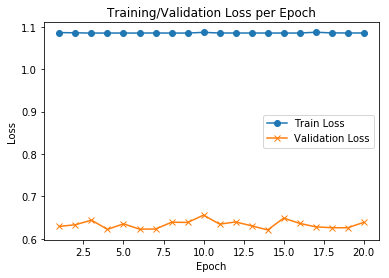

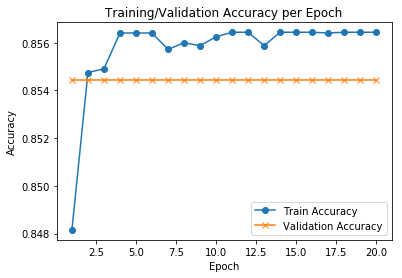

In [12]:
    
PlotHistory(training_history.history['loss'], training_history.history['val_loss'], 'Loss')
PlotHistory(training_history.history['acc'], training_history.history['val_acc'], 'Accuracy')

### Observe Weight Distribution

In [13]:
def drawWeightHistogram(x):
    ## the histogram of the data
    fig = plt.subplots()
    n, bins, patches = plt.hist(x, 50)
    plt.xlim(-0.5, 0.5)
    plt.xlabel('Weight')
    plt.ylabel('Count')
    zero_counts = (x == 0.0).sum()
    plt.title("Weight Histogram. Num of '0's: %d" % zero_counts)

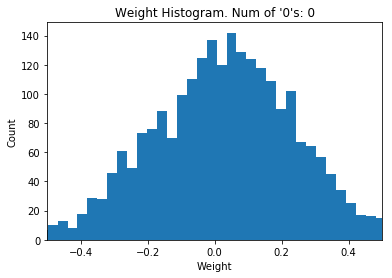

In [14]:
w1 = trained_model.layers[0].get_weights()[0].flatten()
drawWeightHistogram(w1)

### Define Testing Procedure


In [15]:
def TestModel(model=None, data=None):
    if model is None:
        print("Must provide a trained model.")
        return
    if data is None:
        print("Must provide data.")
        
        return
    x_test, y_test = data
    scores = model.evaluate(x_test, y_test)
    return scores

In [16]:
test_score = TestModel(model=trained_model, data=[x_test, y_test])
print("Test loss {:.4f}, fpr {:.2f}%,Accuracy {:.2f}%".format(test_score[0], test_score[1] * 100,test_score[2]*100))


3680/3890 [===========================>..] - ETA: 0sTest loss 0.6400, fpr 15.17%,Accuracy 84.83%
